In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [3]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d

In [4]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [5]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)

In [6]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 77 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [7]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [8]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [9]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [10]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [11]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['weekday'] = df['hour'].apply(date2week)
df['weekday'] = df['weekday'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [12]:
%%time
add_lunar_date(df)

CPU times: user 2min 24s, sys: 1.04 s, total: 2min 25s
Wall time: 2min 27s


In [13]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [14]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [15]:
s[s > 10].index.tolist()[0]

20170315

In [16]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [17]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [18]:
get_prev_date('20170101')

'2016123100'

In [19]:
get_today_from_07('20170101')

'2017010100'

In [20]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [21]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031500 2017031600
2017121100 2017121200
2016113000 2016120100
2017033100 2017040100
2014102300 2014102400
2016102000 2016102100
2014051800 2014051900
2017021200 2017021300
2015071800 2015071900
2014070600 2014070700
2015062700 2015062800
2016083000 2016083100
2017102300 2017102400
2017101200 2017101300
2014122100 2014122200
2017091600 2017091700
2016012200 2016012300
2015040400 2015040500
2015011300 2015011400
2014092500 2014092600
2017060300 2017060400
2016122600 2016122700
2015121300 2015121400
2016030400 2016030500
2015111300 2015111400


600

In [22]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 85 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 no

In [23]:
df.columns

Index(['hour', 'climate', 'weather_deterioration', 'swell', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_수온(°C)', '22490_최대파고(m)', '22490_유의파고(m)', '22490_평균파고(m)',
       '22490_파주기(sec)', '21229_GUST풍속 1(m/s)', '21229_GUST풍속(m/s)',
       '21229_기온(°C)', '21229_수온(°C)', '21229_습도(%)', '21229_유의파고(m)',
       '21229_최대파고(m)', '21229_파주기(sec)', '21229_파향(deg)', '21229_평균파고(m)',
       '21229_풍속(m/s)', '21229_풍속1(m/s)', '21229_풍향(deg)', '21229_풍향1(deg)',
       '21229_현지기압(hPa)', '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)',
       '22105_기온(°C)', '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)',
       '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)', '22105_평균파고(m)',
       '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)', '22105_풍향1(deg)',
       '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)', '22106_GUST풍속(m/s)',
       '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)', '22106_유의파고(m)',
       '22106_최대파고(m)', '22106_파주기(sec)', '221

In [24]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [25]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [26]:
test_date_hour = sorted(test_date_hour)

In [27]:
df.loc[test_date_hour].info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2014051807 to 2017121206
Data columns (total 85 columns):
climate                  600 non-null object
weather_deterioration    600 non-null int64
swell                    0 non-null float64
22453_수온(°C)             558 non-null float64
22453_최대파고(m)            558 non-null float64
22453_유의파고(m)            558 non-null float64
22453_평균파고(m)            558 non-null float64
22453_파주기(sec)           558 non-null float64
22490_수온(°C)             331 non-null float64
22490_최대파고(m)            331 non-null float64
22490_유의파고(m)            331 non-null float64
22490_평균파고(m)            331 non-null float64
22490_파주기(sec)           331 non-null float64
21229_GUST풍속 1(m/s)      119 non-null float64
21229_GUST풍속(m/s)        478 non-null float64
21229_기온(°C)             571 non-null float64
21229_수온(°C)             597 non-null float64
21229_습도(%)              573 non-null float64
21229_유의파고(m)            597 non-null float64
21229_최대파고(m)  

### 테스트 기준 각각 이전의 데이터만 사용하도록 매번 새롭게 학습

In [28]:
test_date_hour

['2014051807',
 '2014051808',
 '2014051809',
 '2014051810',
 '2014051811',
 '2014051812',
 '2014051813',
 '2014051814',
 '2014051815',
 '2014051816',
 '2014051817',
 '2014051818',
 '2014051819',
 '2014051820',
 '2014051821',
 '2014051822',
 '2014051823',
 '2014051900',
 '2014051901',
 '2014051902',
 '2014051903',
 '2014051904',
 '2014051905',
 '2014051906',
 '2014070607',
 '2014070608',
 '2014070609',
 '2014070610',
 '2014070611',
 '2014070612',
 '2014070613',
 '2014070614',
 '2014070615',
 '2014070616',
 '2014070617',
 '2014070618',
 '2014070619',
 '2014070620',
 '2014070621',
 '2014070622',
 '2014070623',
 '2014070700',
 '2014070701',
 '2014070702',
 '2014070703',
 '2014070704',
 '2014070705',
 '2014070706',
 '2014092507',
 '2014092508',
 '2014092509',
 '2014092510',
 '2014092511',
 '2014092512',
 '2014092513',
 '2014092514',
 '2014092515',
 '2014092516',
 '2014092517',
 '2014092518',
 '2014092519',
 '2014092520',
 '2014092521',
 '2014092522',
 '2014092523',
 '2014092600',
 '20140926

In [29]:
%%time

model_scores = []
imp_features = []
preds = [] 

for i,test_date in enumerate(test_date_hour):
    st = time.time()
    all_df = df.loc[:test_date]
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    possible_df = all_df[possible_cols].copy()
    #print(possible_df.iloc[-1][['index','22453_파주기(sec)']])
    possible_df.fillna(method='ffill',inplace=True)
    #print(possible_df.iloc[-1][['index','22453_파주기(sec)']])
    
    train_X = possible_df.iloc[:-1].drop(['swell(t+1)','swell','index','climate','weather_deterioration','day_hour'],axis=1)
    train_y = possible_df.iloc[:-1]['swell(t+1)']
    
    test_X = pd.DataFrame(possible_df.iloc[-1]).T\
                .drop(['swell(t+1)','swell','index','climate','weather_deterioration','day_hour'],axis=1)
    test_y = pd.DataFrame(possible_df.iloc[-1]).T\
                ['swell(t+1)']
    
    model = RandomForestClassifier(n_estimators=200,n_jobs=-1)
    model.fit(train_X,train_y)
    
    pred = model.predict(test_X)
    preds.append(pred[0])
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_features.append(train_X.columns[indices].tolist())
    print(i,'training {} ~ {} size: {}, test {}, {} sec done - pred:{} real:{}, {}'\
              .format(train_X.index[0],train_X.index[-1], len(train_X),test_X.index[0],round(time.time()-st,2),
                      pred[0],test_y[0],pred[0] == test_y[0]))
    

0 training 2014010407 ~ 2014051806 size: 3216, test 2014051807, 0.74 sec done - pred:0.0 real:2.0, False
1 training 2014010407 ~ 2014051807 size: 3217, test 2014051808, 0.71 sec done - pred:0.0 real:2.0, False
2 training 2014010407 ~ 2014051808 size: 3218, test 2014051809, 0.68 sec done - pred:2.0 real:2.0, True
3 training 2014010407 ~ 2014051809 size: 3219, test 2014051810, 0.78 sec done - pred:2.0 real:2.0, True
4 training 2014010407 ~ 2014051810 size: 3220, test 2014051811, 0.69 sec done - pred:2.0 real:2.0, True
5 training 2014010407 ~ 2014051811 size: 3221, test 2014051812, 0.8 sec done - pred:2.0 real:2.0, True
6 training 2014010407 ~ 2014051812 size: 3222, test 2014051813, 0.81 sec done - pred:2.0 real:2.0, True
7 training 2014010407 ~ 2014051813 size: 3223, test 2014051814, 0.8 sec done - pred:2.0 real:2.0, True
8 training 2014010407 ~ 2014051814 size: 3224, test 2014051815, 0.87 sec done - pred:2.0 real:2.0, True
9 training 2014010407 ~ 2014051815 size: 3225, test 2014051816, 

79 training 2014010407 ~ 2014102313 size: 7015, test 2014102314, 1.1 sec done - pred:2.0 real:2.0, True
80 training 2014010407 ~ 2014102314 size: 7016, test 2014102315, 1.1 sec done - pred:2.0 real:2.0, True
81 training 2014010407 ~ 2014102315 size: 7017, test 2014102316, 1.11 sec done - pred:2.0 real:2.0, True
82 training 2014010407 ~ 2014102316 size: 7018, test 2014102317, 1.1 sec done - pred:2.0 real:2.0, True
83 training 2014010407 ~ 2014102317 size: 7019, test 2014102318, 1.23 sec done - pred:2.0 real:2.0, True
84 training 2014010407 ~ 2014102318 size: 7020, test 2014102319, 1.21 sec done - pred:2.0 real:2.0, True
85 training 2014010407 ~ 2014102319 size: 7021, test 2014102320, 1.09 sec done - pred:2.0 real:2.0, True
86 training 2014010407 ~ 2014102320 size: 7022, test 2014102321, 1.1 sec done - pred:2.0 real:2.0, True
87 training 2014010407 ~ 2014102321 size: 7023, test 2014102322, 1.1 sec done - pred:2.0 real:2.0, True
88 training 2014010407 ~ 2014102322 size: 7024, test 2014102

157 training 2014010407 ~ 2015040419 size: 10933, test 2015040420, 1.33 sec done - pred:0.0 real:0.0, True
158 training 2014010407 ~ 2015040420 size: 10934, test 2015040421, 1.32 sec done - pred:0.0 real:0.0, True
159 training 2014010407 ~ 2015040421 size: 10935, test 2015040422, 1.41 sec done - pred:0.0 real:0.0, True
160 training 2014010407 ~ 2015040422 size: 10936, test 2015040423, 1.24 sec done - pred:0.0 real:0.0, True
161 training 2014010407 ~ 2015040423 size: 10937, test 2015040500, 1.28 sec done - pred:0.0 real:0.0, True
162 training 2014010407 ~ 2015040500 size: 10938, test 2015040501, 1.39 sec done - pred:0.0 real:0.0, True
163 training 2014010407 ~ 2015040501 size: 10939, test 2015040502, 1.52 sec done - pred:0.0 real:0.0, True
164 training 2014010407 ~ 2015040502 size: 10940, test 2015040503, 1.33 sec done - pred:0.0 real:0.0, True
165 training 2014010407 ~ 2015040503 size: 10941, test 2015040504, 1.3 sec done - pred:0.0 real:0.0, True
166 training 2014010407 ~ 2015040504 s

234 training 2014010407 ~ 2015111400 size: 16290, test 2015111401, 1.82 sec done - pred:2.0 real:2.0, True
235 training 2014010407 ~ 2015111401 size: 16291, test 2015111402, 1.73 sec done - pred:2.0 real:2.0, True
236 training 2014010407 ~ 2015111402 size: 16292, test 2015111403, 1.74 sec done - pred:2.0 real:2.0, True
237 training 2014010407 ~ 2015111403 size: 16293, test 2015111404, 1.73 sec done - pred:2.0 real:2.0, True
238 training 2014010407 ~ 2015111404 size: 16294, test 2015111405, 1.83 sec done - pred:2.0 real:2.0, True
239 training 2014010407 ~ 2015111405 size: 16295, test 2015111406, 1.82 sec done - pred:2.0 real:2.0, True
240 training 2014010407 ~ 2015121306 size: 16992, test 2015121307, 1.95 sec done - pred:2.0 real:2.0, True
241 training 2014010407 ~ 2015121307 size: 16993, test 2015121308, 2.07 sec done - pred:2.0 real:2.0, True
242 training 2014010407 ~ 2015121308 size: 16994, test 2015121309, 1.84 sec done - pred:2.0 real:2.0, True
243 training 2014010407 ~ 2015121309 

311 training 2014010407 ~ 2016030505 size: 18983, test 2016030506, 2.05 sec done - pred:0.0 real:1.0, False
312 training 2014010407 ~ 2016083006 size: 23256, test 2016083007, 2.45 sec done - pred:2.0 real:2.0, True
313 training 2014010407 ~ 2016083007 size: 23257, test 2016083008, 3.06 sec done - pred:2.0 real:2.0, True
314 training 2014010407 ~ 2016083008 size: 23258, test 2016083009, 2.56 sec done - pred:2.0 real:2.0, True
315 training 2014010407 ~ 2016083009 size: 23259, test 2016083010, 2.49 sec done - pred:2.0 real:2.0, True
316 training 2014010407 ~ 2016083010 size: 23260, test 2016083011, 2.41 sec done - pred:2.0 real:2.0, True
317 training 2014010407 ~ 2016083011 size: 23261, test 2016083012, 2.4 sec done - pred:2.0 real:2.0, True
318 training 2014010407 ~ 2016083012 size: 23262, test 2016083013, 2.4 sec done - pred:2.0 real:2.0, True
319 training 2014010407 ~ 2016083013 size: 23263, test 2016083014, 2.39 sec done - pred:2.0 real:2.0, True
320 training 2014010407 ~ 2016083014 s

388 training 2014010407 ~ 2016122610 size: 26092, test 2016122611, 2.81 sec done - pred:0.0 real:0.0, True
389 training 2014010407 ~ 2016122611 size: 26093, test 2016122612, 2.62 sec done - pred:0.0 real:0.0, True
390 training 2014010407 ~ 2016122612 size: 26094, test 2016122613, 2.7 sec done - pred:0.0 real:0.0, True
391 training 2014010407 ~ 2016122613 size: 26095, test 2016122614, 2.91 sec done - pred:0.0 real:0.0, True
392 training 2014010407 ~ 2016122614 size: 26096, test 2016122615, 2.73 sec done - pred:0.0 real:0.0, True
393 training 2014010407 ~ 2016122615 size: 26097, test 2016122616, 3.0 sec done - pred:0.0 real:0.0, True
394 training 2014010407 ~ 2016122616 size: 26098, test 2016122617, 2.82 sec done - pred:0.0 real:0.0, True
395 training 2014010407 ~ 2016122617 size: 26099, test 2016122618, 2.69 sec done - pred:0.0 real:0.0, True
396 training 2014010407 ~ 2016122618 size: 26100, test 2016122619, 2.82 sec done - pred:0.0 real:0.0, True
397 training 2014010407 ~ 2016122619 si

465 training 2014010407 ~ 2017033115 size: 28377, test 2017033116, 3.62 sec done - pred:0.0 real:0.0, True
466 training 2014010407 ~ 2017033116 size: 28378, test 2017033117, 2.98 sec done - pred:0.0 real:0.0, True
467 training 2014010407 ~ 2017033117 size: 28379, test 2017033118, 2.96 sec done - pred:0.0 real:0.0, True
468 training 2014010407 ~ 2017033118 size: 28380, test 2017033119, 2.99 sec done - pred:0.0 real:0.0, True
469 training 2014010407 ~ 2017033119 size: 28381, test 2017033120, 2.97 sec done - pred:0.0 real:0.0, True
470 training 2014010407 ~ 2017033120 size: 28382, test 2017033121, 3.07 sec done - pred:0.0 real:0.0, True
471 training 2014010407 ~ 2017033121 size: 28383, test 2017033122, 2.89 sec done - pred:0.0 real:0.0, True
472 training 2014010407 ~ 2017033122 size: 28384, test 2017033123, 3.15 sec done - pred:0.0 real:0.0, True
473 training 2014010407 ~ 2017033123 size: 28385, test 2017040100, 2.97 sec done - pred:0.0 real:0.0, True
474 training 2014010407 ~ 2017040100 

542 training 2014010407 ~ 2017101220 size: 33062, test 2017101221, 3.42 sec done - pred:0.0 real:0.0, True
543 training 2014010407 ~ 2017101221 size: 33063, test 2017101222, 3.58 sec done - pred:0.0 real:0.0, True
544 training 2014010407 ~ 2017101222 size: 33064, test 2017101223, 3.82 sec done - pred:0.0 real:0.0, True
545 training 2014010407 ~ 2017101223 size: 33065, test 2017101300, 3.84 sec done - pred:0.0 real:0.0, True
546 training 2014010407 ~ 2017101300 size: 33066, test 2017101301, 3.54 sec done - pred:0.0 real:0.0, True
547 training 2014010407 ~ 2017101301 size: 33067, test 2017101302, 3.61 sec done - pred:0.0 real:0.0, True
548 training 2014010407 ~ 2017101302 size: 33068, test 2017101303, 3.51 sec done - pred:0.0 real:0.0, True
549 training 2014010407 ~ 2017101303 size: 33069, test 2017101304, 3.6 sec done - pred:0.0 real:0.0, True
550 training 2014010407 ~ 2017101304 size: 33070, test 2017101305, 3.4 sec done - pred:0.0 real:0.0, True
551 training 2014010407 ~ 2017101305 si

In [ ]:
test = df.loc[test_date_hour][['swell(t+1)']].fillna(method='ffill')
test['pred'] = preds
test['proba'] = probas
test

In [31]:
test['pred_swell'] = test['pred'].apply(lambda x: output_change(x))

In [32]:
test['pred_swell'].value_counts()

0    409
1    191
Name: pred_swell, dtype: int64

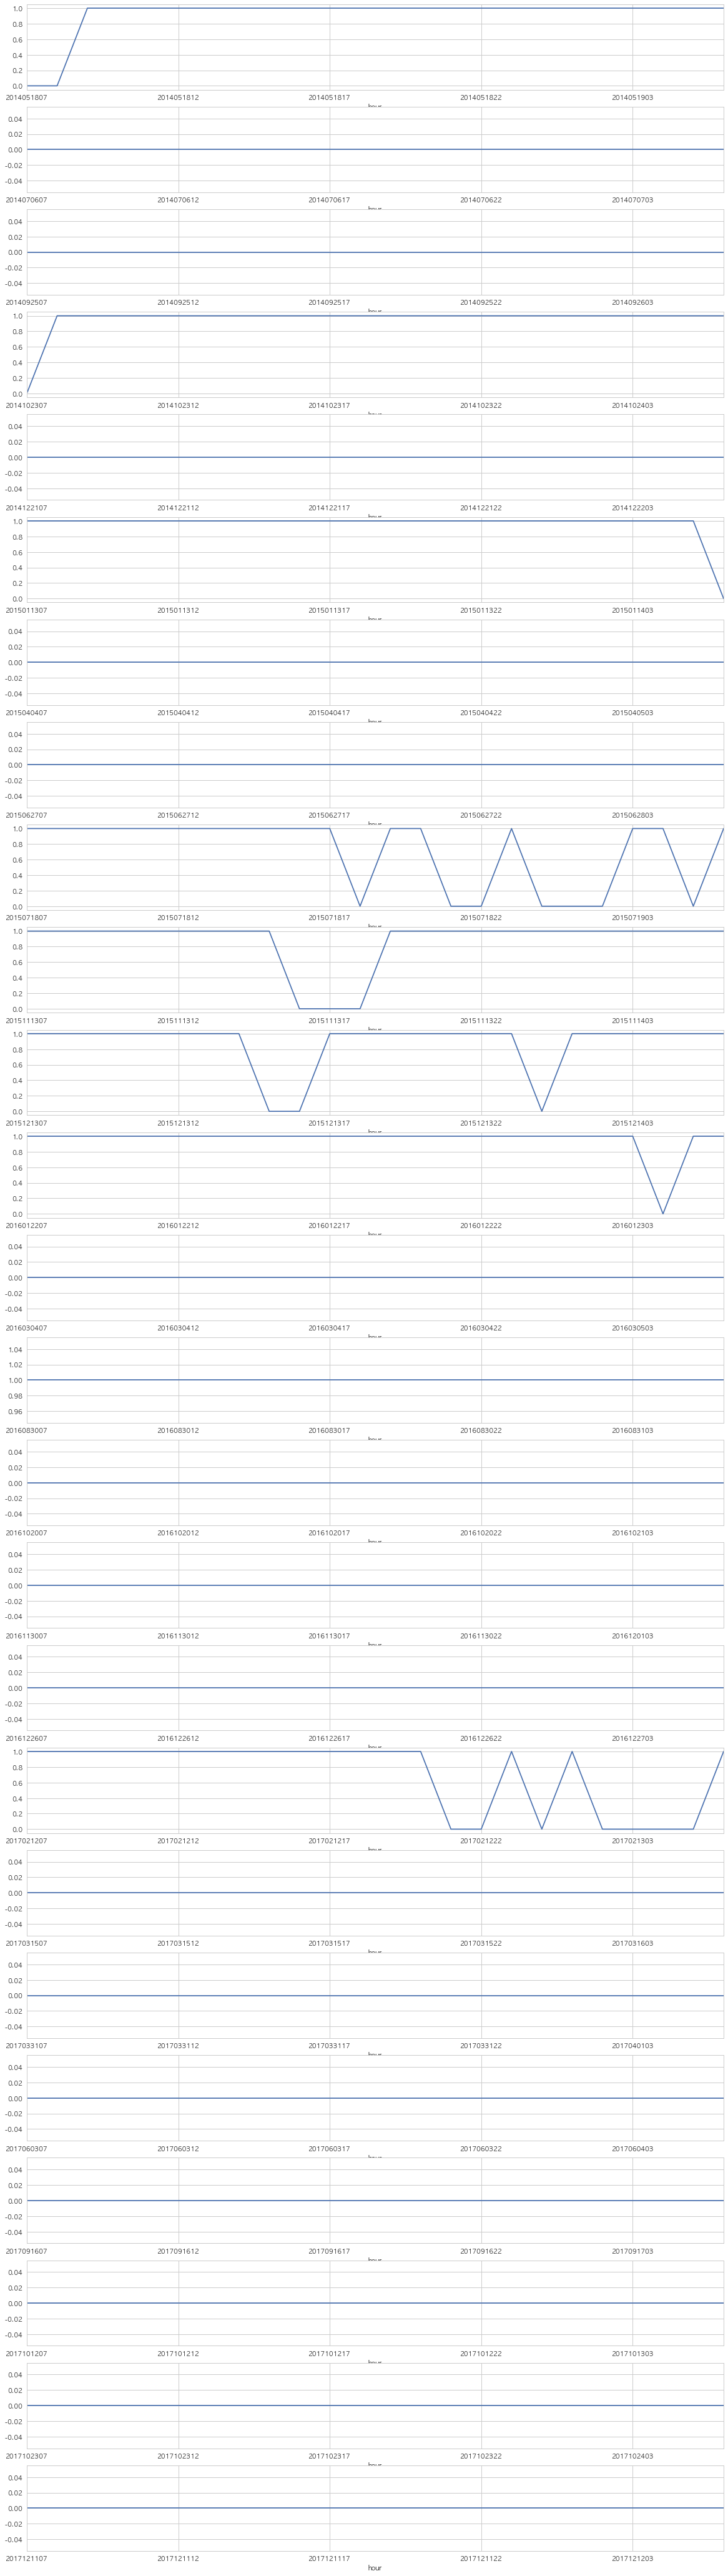

In [33]:
index = 0
for i in range(25):
    index = i*24
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()

In [34]:
index=0
test.iloc[index:index+24].T

hour,2014051807,2014051808,2014051809,2014051810,2014051811,2014051812,2014051813,2014051814,2014051815,2014051816,...,2014051821,2014051822,2014051823,2014051900,2014051901,2014051902,2014051903,2014051904,2014051905,2014051906
swell(t+1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
pred,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
pred_swell,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
mat =[]
for i in range(int(600/24)):
    index=24*i
    #print(test.sort_index().iloc[index:index+24].T.loc[['pred_swell']])
    print(test.iloc[index:index+24]['pred_swell'].value_counts())
    mat.append(test.sort_index().iloc[index:index+24].T.loc['pred_swell'].tolist())

1    22
0     2
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
1    23
0     1
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
1    23
0     1
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
1    17
0     7
Name: pred_swell, dtype: int64
1    21
0     3
Name: pred_swell, dtype: int64
1    21
0     3
Name: pred_swell, dtype: int64
1    23
0     1
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
1    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
1    17
0     7
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64
0    24
Name: pred_swell, dtype: int64


In [36]:
mat =[]
for i in range(int(600/24)):
    index=24*i
    print(test.sort_index().iloc[index:index+24].T.loc[['pred']])
    mat.append(test.sort_index().iloc[index:index+24].T.loc['pred'].tolist())

hour  2014051807  2014051808  2014051809  2014051810  2014051811  2014051812  \
pred         0.0         0.0         2.0         2.0         2.0         2.0   

hour  2014051813  2014051814  2014051815  2014051816     ...      2014051821  \
pred         2.0         2.0         2.0         2.0     ...             2.0   

hour  2014051822  2014051823  2014051900  2014051901  2014051902  2014051903  \
pred         2.0         2.0         2.0         2.0         2.0         2.0   

hour  2014051904  2014051905  2014051906  
pred         2.0         2.0         2.0  

[1 rows x 24 columns]
hour  2014070607  2014070608  2014070609  2014070610  2014070611  2014070612  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2014070613  2014070614  2014070615  2014070616     ...      2014070621  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2014070622  2014070623  2014070700  2014070701  2014070702  2014070703  \
pred  

[1 rows x 24 columns]
hour  2017091607  2017091608  2017091609  2017091610  2017091611  2017091612  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2017091613  2017091614  2017091615  2017091616     ...      2017091621  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2017091622  2017091623  2017091700  2017091701  2017091702  2017091703  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2017091704  2017091705  2017091706  
pred         0.0         0.0         0.0  

[1 rows x 24 columns]
hour  2017101207  2017101208  2017101209  2017101210  2017101211  2017101212  \
pred         0.0         0.0         0.0         0.0         0.0         0.0   

hour  2017101213  2017101214  2017101215  2017101216     ...      2017101221  \
pred         0.0         0.0         0.0         0.0     ...             0.0   

hour  2017101222  2017101223  2017101300  2017101301  2017101302

In [37]:
imp_features

[['22106_습도(%)',
  '22453_최대파고(m)',
  '22453_유의파고(m)',
  '22453_평균파고(m)',
  '22106_풍향1(deg)',
  '21229_풍향1(deg)',
  '22105_풍향1(deg)',
  '22106_유의파고(m)',
  '22106_수온(°C)',
  '21229_기온(°C)'],
 ['22106_습도(%)',
  '22453_유의파고(m)',
  '22453_평균파고(m)',
  '22453_최대파고(m)',
  '22105_풍향1(deg)',
  '21229_풍향1(deg)',
  '22106_유의파고(m)',
  '22106_평균파고(m)',
  '22106_풍향1(deg)',
  '22105_현지기압(hPa)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '22453_최대파고(m)',
  '22453_유의파고(m)',
  '21229_풍향1(deg)',
  '22106_풍향1(deg)',
  '22105_풍향1(deg)',
  '22106_평균파고(m)',
  '21229_기온(°C)',
  '22105_수온(°C)'],
 ['22453_평균파고(m)',
  '22106_습도(%)',
  '22453_유의파고(m)',
  '22453_최대파고(m)',
  '22105_풍향1(deg)',
  '21229_풍향1(deg)',
  '22106_풍향1(deg)',
  '22106_유의파고(m)',
  '22106_평균파고(m)',
  '22105_현지기압(hPa)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '22453_최대파고(m)',
  '22453_유의파고(m)',
  '22106_풍향1(deg)',
  '21229_풍향1(deg)',
  '22105_풍향1(deg)',
  '22106_유의파고(m)',
  '22106_수온(°C)',
  '22105_기온(°C)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '224

In [38]:
#pd.DataFrame(np.array(mat)).to_csv('./sub22_swell.csv')